In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
import tensorflow as tf

sys.path.append('..')
from DCN import DCN
import dcn_callbacks as dcn_call

2021-12-11 18:32:48.025607: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2021-12-11 18:32:48.025629: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Create artificial test data for demonstration

The example is described in the original paper (http://arxiv.org/abs/1610.04794):

* Generate 2-dimensional data $X$ that is "friendly" to cluster.
* Apply non-linear transformations $t(\cdot)$ to generate $\tilde{X}=t(X)\subset\mathbb{R}^{100}$ such that original k-means has troubles to infer the ground truth labels from $\tilde{X}$. We want DCN to be able to detect the clustering-friendly structure (that we know exists).

In [2]:
# We create the clustering friendly data by samples from four Gaussian

# define parameters
centers = [(0,0),
           (10,0),
           (0,10),
           (10,10)]
spread = 1
points_per_cluster = 2500
orig_data_dim = 2

# sample from Gaussians 
X = [np.random.normal(loc=center, scale=spread, size=(points_per_cluster, orig_data_dim)) for center in centers]
X = np.array(X).reshape((-1,2))

#### Verify "k-means-friendliness" and visualize original data

In [3]:
def visualize_2d_data(X, title='Data visualized', hue=None, centers=None):
    """
    Simple function for quick-and-dirty visualization of 2d data.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    
    fig_scatter = sns.scatterplot(x=X[:,0],
                                  y=X[:,1],
                                  hue=hue,
                                  ax=ax)
    if not centers is None:
        ax.scatter(centers[:,0], centers[:,1],
                      marker='x',
                      c='cyan',
                      s=75)
    fig_scatter.set_title(title)
    
    return fig_scatter

In [4]:
kmeans_model = KMeans(n_clusters=len(centers), 
                      random_state=43,
                      init='k-means++'
                     )
# this fits the model and directly gives a vector of cluster assignments (i-th entry corresponds to i-th point's cluster label)
kmeans_assignments = kmeans_model.fit_predict(X)

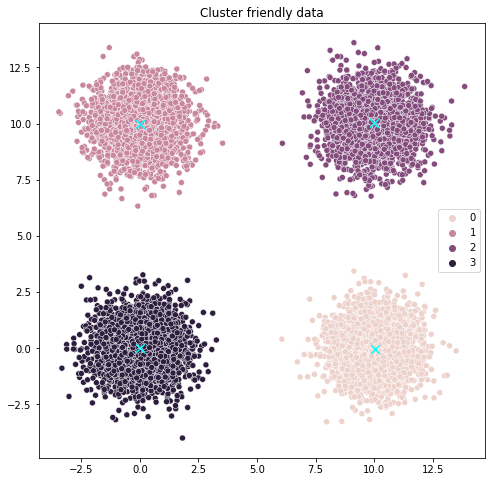

In [5]:
# Indeed, we have four nicely seperated clusters that k-means was able to detect.
fig_orig_cluster = visualize_2d_data(X, title='Cluster friendly data', 
                                     hue=kmeans_assignments, centers=kmeans_model.cluster_centers_)

#### Apply transformations to create $\tilde{X}$

In [6]:
sigmoid = lambda x: 1/(1+np.exp(-x)) # to introduce non-linearities

def obfuscate_X(X):
    """
    Obfuscate X by multiplication with random values and applying non-linear transformations.
    """
    W = np.random.normal(loc=(0,0), scale=1, size=(10,2))
    U = np.random.normal(loc=0, scale=1, size=(100,10))
    
    X_obf = [np.dot(U, sigmoid(np.dot(W, x))) for x in X]
    X_obf = np.array(X_obf).reshape(-1, 100)
    
    return X_obf

In [7]:
X_tilde = obfuscate_X(X)

In [8]:
X_tilde.shape

(10000, 100)

In [9]:
# we can not (directly) visualize the data, but let's check whether k-means is still able to detect ground truth clusters
kmeans_tilde = KMeans(n_clusters=len(centers), 
                      random_state=43,
                      init='k-means++'
                     )
assignments_tilde = kmeans_tilde.fit_predict(X_tilde)

In [10]:
nmi_obf = np.round(100*normalized_mutual_info_score(kmeans_assignments, assignments_tilde), 2)
print('The ground truth assignments are found in {}% of cases.'.format(nmi_obf))

The ground truth assignments are found in 83.39% of cases.


This is not terrible, but considering how easy the original data is to cluster, this leaves room for improvement.

Let's see whether DCN can still identify und utilize the original data's structure.

### Run DCN

In [11]:
batch_size = 64
pretrain_epochs = 75
train_epochs = 75

# weigh clustering loss against reconstruction loss
clust_loss_weight = 200 # contrarily to the paper's claim, this seems to be a very important parameter
learning_rate = 0.0005

save_dir = os.path.abspath('./intermediate_clustering')
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print('Created {0}'.format(save_dir))

In [12]:
# define callback
fig_saver = dcn_call.PlotClusters2D(X_all=X_tilde, 
                           true_assignments=kmeans_assignments,
                           save_dir=save_dir,
                         every_x_epoch=10) # to track intermediate clustering results (only works for 2D data)
clust_learn_updater = dcn_call.ClustLearningRateUpdater() # we reset the learning rate in the batch k-means formulation. Otherwise, it the changes would be too little after a few epochs

In [13]:
dcn_model = DCN(latent_dim=orig_data_dim,
                input_dim=X_tilde.shape[1],
                n_clusters=len(centers),
                lamda=clust_loss_weight)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

dcn_model.compile(run_eagerly=True, 
                  optimizer=optimizer)

2021-12-11 18:32:50.981176: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-11 18:32:50.981560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2021-12-11 18:32:50.981612: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2021-12-11 18:32:50.981660: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_

In [14]:
# This pretrains the auto-encoder part as suggested in the DCN paper
dcn_model.pretrain(X_tilde, 
                   epochs=pretrain_epochs,
                   batch_size=batch_size,
                   verbose=True)

2021-12-11 18:32:54 - Epoch 0 - Reconstruction loss: 12.121102333068848.
2021-12-11 18:32:57 - Epoch 1 - Reconstruction loss: 10.999425888061523.
2021-12-11 18:33:01 - Epoch 2 - Reconstruction loss: 13.02078914642334.
2021-12-11 18:33:05 - Epoch 3 - Reconstruction loss: 8.672273635864258.
2021-12-11 18:33:08 - Epoch 4 - Reconstruction loss: 7.2564520835876465.
2021-12-11 18:33:12 - Epoch 5 - Reconstruction loss: 6.3693389892578125.
2021-12-11 18:33:15 - Epoch 6 - Reconstruction loss: 5.348113059997559.
2021-12-11 18:33:19 - Epoch 7 - Reconstruction loss: 4.941505432128906.
2021-12-11 18:33:23 - Epoch 8 - Reconstruction loss: 3.8046844005584717.
2021-12-11 18:33:26 - Epoch 9 - Reconstruction loss: 3.3344428539276123.
2021-12-11 18:33:30 - Epoch 10 - Reconstruction loss: 2.9488799571990967.
2021-12-11 18:33:34 - Epoch 11 - Reconstruction loss: 2.495206356048584.
2021-12-11 18:33:37 - Epoch 12 - Reconstruction loss: 2.9352126121520996.
2021-12-11 18:33:41 - Epoch 13 - Reconstruction loss:

In [15]:
dcn_model.fit(X_tilde, X_tilde, 
              shuffle=True,
              batch_size=batch_size,
              epochs=train_epochs,
              callbacks=[clust_learn_updater,
                         fig_saver])

Epoch 1/75
157/157 [==============================] - 16s 101ms/step - loss: 1305.4246 - recon_loss: 33.6387 - cluster_loss: 1271.7859
Epoch 2/75
157/157 [==============================] - 17s 105ms/step - loss: 513.5907 - recon_loss: 32.1586 - cluster_loss: 481.4321
Epoch 3/75
157/157 [==============================] - 16s 101ms/step - loss: 381.9434 - recon_loss: 32.2646 - cluster_loss: 349.6787
Epoch 4/75
157/157 [==============================] - 15s 97ms/step - loss: 327.1161 - recon_loss: 32.3130 - cluster_loss: 294.8031
Epoch 5/75
157/157 [==============================] - 17s 107ms/step - loss: 311.4618 - recon_loss: 32.3855 - cluster_loss: 279.0762
Epoch 6/75
157/157 [==============================] - 16s 100ms/step - loss: 286.6299 - recon_loss: 32.7581 - cluster_loss: 253.8717
Epoch 7/75
157/157 [==============================] - 16s 103ms/step - loss: 269.2556 - recon_loss: 32.6188 - cluster_loss: 236.6369
Epoch 8/75
157/157 [==============================] - 16s 100ms/step

157/157 [==============================] - 16s 101ms/step - loss: 137.2971 - recon_loss: 33.0978 - cluster_loss: 104.1993
Epoch 62/75
157/157 [==============================] - 16s 99ms/step - loss: 133.2296 - recon_loss: 32.9857 - cluster_loss: 100.2439
Epoch 63/75
157/157 [==============================] - 15s 94ms/step - loss: 144.0465 - recon_loss: 32.9598 - cluster_loss: 111.0867
Epoch 64/75
157/157 [==============================] - 15s 95ms/step - loss: 142.1560 - recon_loss: 32.9680 - cluster_loss: 109.1879
Epoch 65/75
157/157 [==============================] - 15s 97ms/step - loss: 136.6607 - recon_loss: 33.1258 - cluster_loss: 103.5348
Epoch 66/75
157/157 [==============================] - 16s 99ms/step - loss: 150.8860 - recon_loss: 33.1401 - cluster_loss: 117.74590s - loss: 152.0201 - recon_loss: 33.3530 - cluster_loss: 11
Epoch 67/75
157/157 [==============================] - 16s 101ms/step - loss: 138.4487 - recon_loss: 32.9762 - cluster_loss: 105.4725
Epoch 68/75
157/157

##### Plot how loss changed over time

In [16]:
total_loss = dcn_model.history.history['loss']
recon_loss = dcn_model.history.history['recon_loss']
cluster_loss = dcn_model.history.history['cluster_loss']
epochs = dcn_model.history.epoch

In [17]:
hist_df = pd.DataFrame({'epoch':epochs,
                        'total_loss':total_loss,
                        'recon_loss':recon_loss,
                        'cluster_loss':cluster_loss})

<AxesSubplot:xlabel='epoch', ylabel='value'>

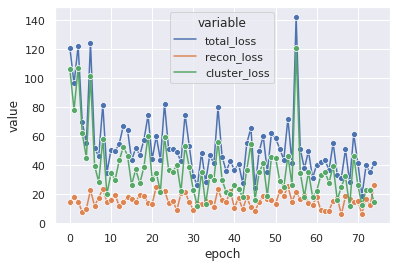

In [18]:
sns.lineplot(x='epoch',
             y='value',
             hue='variable',
             data=pd.melt(hist_df, 'epoch'),
             marker='o'
            )

#### Visualize DCN results and compare to ground truth

In [19]:
# DCN's clustering is done in the latent space. So, we first get the learned latent representations
latent_x = dcn_model.encoder(X_tilde) 
# ... and the the assignments
deep_assignments = dcn_model.get_assignment(latent_x)

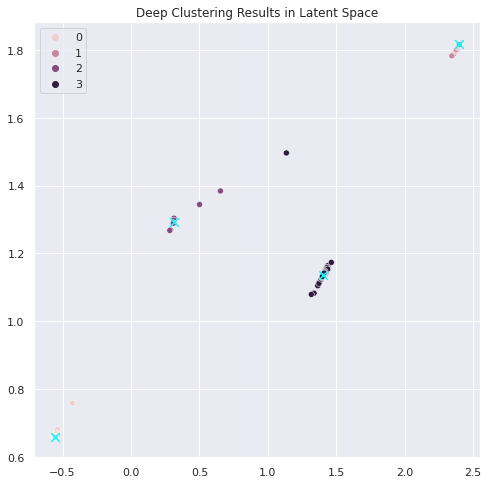

In [20]:
deep_clust_fig = visualize_2d_data(latent_x, 
                                  title='Deep Clustering Results in Latent Space', 
                                  hue=deep_assignments, 
                                  centers=dcn_model.centers)

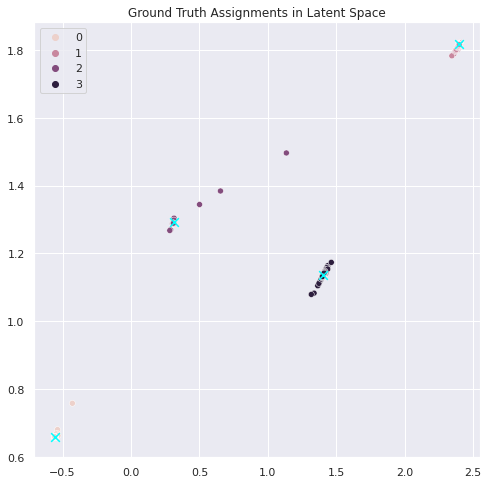

In [21]:
# let us compare this against the ground truth assignments by looking at them in the latent space
deep_clust_fig = visualize_2d_data(latent_x, 
                                  title='Ground Truth Assignments in Latent Space', 
                                  hue=kmeans_assignments, 
                                  centers=dcn_model.centers)

In [22]:
# finally, let us calculate the NMI score with deep assignments
nmi_deep = np.round(100*normalized_mutual_info_score(kmeans_assignments, deep_assignments), 2)
print('The ground truth assignments could be found in {}% of cases using DCN.'.format(nmi_deep))

The ground truth assignments could be found in 99.94% of cases using DCN.
